<div style="text-align: right">INFO 6106 Neural Modeling, Lecture 14 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 16 April 2024</div>

# Stable diffusion
<br />
<center>
<img src="ipynb.images/huskies-on-mars.png" width=900 />
</center>

You will need a version of tensorflow $\ge$ to 12.2. Otherwise, you will need to install the latest, although I=the latest is version 2.16.1, and I had problems with that.

But you will have to install `keras_cv`. Combined with tensorflow, you can run the following:

```
pip install tensorflow keras_cv --upgrade --quiet
```

There's a problem though: The Python standard library `resource` is not available on windows. But as the code that produces this error *only* tries to increase the number of allowed file handles it probably will not cause any trouble in most cases if it is missing.

On Windows, in the file \Lib\site-packages\tensorflow_datasets\core\shuffle.py replacee the body of the method `_increase_open_files_limit()` with a `pass` and removed the line `import resource`.

Then, restart your anaconda kernel, and run the following cell. You could also try the following cell first to uncover the error on Windows (if it happens).

You should be ble to run this cell succcessfully on Mac.

In [2]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

# 1. Variational Autoencoders
When you want to alter or explore variations on data you already have,
not just in a random way, but in a desired, specific direction, this is where
Variational autoencoders (VAE) work better than any other method.

## Into a thought vector and back
An autoencoder network is an encoder-decoder. The encoder network takes in an input, like Beethoven's 9th symphony, converts it into a smaller, dense
representation like the one in your brain for the ninth symphony, and then the decoder converts it back to the original sound, just like we did for number addition.

So, autoencoders generate encodings specifically useful for reconstructing their own input.
<br />
<center>
<img src="ipynb.images/thought-vector-o.png" width=700 />
</center>

The encoder learns to compress as much as possible the relevant information into a thought vector.

## The problem with standard autoencoders
Standard autoencoders learn to generate compact representations and reconstruct their
inputs well, but the fundamental problem with autoencoders for generation is that the latent space
they convert their inputs to and where their encoded vectors lie is not continuous and does not allow for easy interpolation.

If we were to take the thought vector we worked on for MNIST digits and project it into 2D with t-SNE, this is what we would get:

<br />
<center>
<img src="ipynb.images/thought-vector-mnist-2.png" width=700 />
</center>

The plot reveals the formation of distinct clusters. In fact, the more distinct the clusters are, the better off for classification purposes. We relied on that property to build SVMs, and the more clustery the data is, the better for accurate neural network predictions, too. 

But if we're after a *generative model* rather that a classifying or regression model, we don’t want to to replicate the
same image we put in. We want to randomly sample from the latent space to generate
variations on an input image.

But if the latent space has discontinuities, gaps between clusters like above, and we sample/generate a
variation from there, the decoder will simply generate an unrealistic output because it has litterally no idea how to deal with that region of the latent space. During training, it never saw encoded vectors coming from that region of latent space!

## Variational autoencoders
Variational Autoencoders have one fundamentally unique property that
separates them from vanilla autoencoders, and it is this property that makes them so
useful for generative modeling: Their latent spaces are, by design, continuous, allowing
easy random sampling and interpolation!

They achieve this by doing something that seems rather surprising at first: Making its
encoder not output an encoding vector of size $n$, but rather outputting *two* vectors of size $n$:
a vector of means, $μ$, and another vector of standard deviations, $σ$.

This implicitely means that we are now odeling thought vectors as gaussian distributions using `pymc3`. If our class continued on, I would give you homework to do exactly that.

So the $i$th element of $μ$ and $σ$ are the mean and standard deviation of the $i$th observation $X$.

<br />
<center>
<img src="ipynb.images/vae-mu-sig.png" width=500 />
</center>

We sample from the $i$th element of $μ$ and $σ$ to obtain the sampled encoding which we pass onward to the decoder.

This stochastic generation means, that even for the same input, while the mean and standard deviations remain the same, the actual decoding will somewhat vary on every single pass simply due to sampling.

<br />
<center>
<img src="ipynb.images/ml-std-vs-vae.png" width=700 />
</center>

The mean vector controls where the encoding of an input should be centered around and the standard deviation controls the *area*, how much from the mean the encoding can vary. 

As encodings are generated at random from anywhere inside the distribution of the thought vector, the decoder learns that not only is a single point in latent space referring to a sample of that class, but that all nearby points refer to the same as well. 

This allows the decoder to not just decode single specific encodings in the latent space, leaving the decodable latent space discontinuous, but ones that slightly vary too, as the decoder is exposed to a range of variations of the encoding of the same input during training.

This is the Keras code from a standard VAE:
```
latent_size = 5
mean = Dense(latent_size)(hidden)

# (simplified: we usually don't directly compute the stddev σ 
# but the log of the stddev instead, which is log(σ))
log_stddev = Dense(latent_size)(hidden)

def sampler(mean, log_stddev):
    # we sample from the standard normal a matrix of batch_size * latent_size (taking into account minibatches)
    std_norm = K.random_normal(shape=(K.shape(mean)[0], latent_size), mean=0, stddev=1)
    
    # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σX, X~N(0,1)
    return mean + K.exp(log_stddev) * std_norm
  
latent_vector = Lambda(sampler)([mean, log_stddev])
# pass latent_vector as input to decoder layers
```

The model is now exposed to a certain degree of local variation by varying the encoding of one sample, resulting in smooth latent spaces on a local scale, that is, for similar samples. 

We also want overlap between samples that are not very similar too, in order to interpolate between classes. 

There are no limits on what values vectors $μ$ and $σ$ can take on, and so the encoder can learn to generate very different $μ$'s for different classes, clustering the thought vectors apart, and minimizing $σ$, making sure the thought vectors don’t vary much for the same sample, which allows the decoder to efficiently reconstruct the training data.

That's all great, but we also want thought vectors that are as close as possible to each other while still being distinct, allowing smooth interpolation and enabling the construction of *new* samples.

In order to force this, we introduce the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL) into the loss function. The KL divergence between two probability distributions simply measures how much they diverge from each other, or how surprised we would be to use one distribution versus an expected other. 

Minimizing the KL divergence means optimizing the probability distribution parameters ($μ$ and $σ$) to closely resemble that of the target distribution.

For VAEs, the KL loss is equivalent to the sum of all the KL divergences between the component $X_i$ and the standard normal $ \mathcal{N}(μ_i, σ_i²)$.

Encoding the KL loss into our network loss function encourages the encoder to distribute all thought vectors uniformly around the center of the latent space. If it clusters them too much apart into specific regions, it will be penalized.

So a VAE is a careful balance between bringing the thought vectors close to each other, while still keeping them slightly apart. It's a compression of thought vector space.
```
def vae_loss(input_img, output):
    # compute the average MSE error, then scale it up i.e. simply sum on all axes
    reconstruction_loss = K.sum(K.square(output-input_img))
    # compute the KL loss
    kl_loss = -0.5 * K.sum(1 + log_stddev - K.square(mean) - K.square(K.exp(log_stddev)), axis=-1)
    # return the average loss over all images in batch
    total_loss = K.mean(reconstruction_loss + kl_loss)
    return total_loss
```

If we compress too much, we get this, which is not good because thought vectors don't allow us to distinguish between MNIST digits:

<br />
<center>
<img src="ipynb.images/ml-vae-too-much-compression.png" width=500 />
</center>

Optimizing the two together, however, results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin (compare the axes below with the original far above):

<br />
<center>
<img src="ipynb.images/ml-vae-just-right.png" width=600 />
</center>

This equilibrium is reached by the cluster-forming nature of the reconstruction loss and the dense packing nature of the KL loss, forming distinct clusters the decoder can decode. So when randomly generating from latent space (thought vector space), if we sample a vector from the same prior distribution ofencoded vectors, the decoder will successfully decode it. And if we’re interpolating, there are no sudden gaps between clusters leading to reconstruction *hallucinations*, but a smooth mix of features the decoder can understand.

## Smooth interpolations
So how do we actually produce these smooth interpolations we speak of?

It's just matrix compression in thought vector space. If we wish to generate a new sample halfway between two samples, we can find the difference between their mean (μ) vectors, add half the difference to the original, and then simply decode it. But we can do better: The determinant of a matrix is the amount of compression when multipliying any vector of the source vector space with that matrix, so picking an appropriate matrix, or even a latent non-linear kernel transformation, will result in more densely packed clusters, leading to able to control hallucinations (that's my thinking in my research with Devesh, but Devesh has fallen behind and we still have not been able to conduct *any* experiments and it's the end of the semester already...).

Synthetic human faces with CNNs, or how smiley a face can be as a result of your take-home-homework prediction are examples of *interpolations* from latent space, how different they look from the ones used to train the network is exactly what we call hallucinations in chatGPT.

VAEs work with diverse types of data, sequential or non-sequential, continuous or discrete, even labelled or completely unlabelled, making them highly powerful generative tools. 

I felt it was important to understand the *generative* nature of network, so we can understand how stable diffusion networks work.

# 2. Superresolution
It all started with the concept of *superresolution*: A deep learning model trained to denoise an input image -- and thereby turn it into a higher-resolution version. 

The deep learning model doesn't do this by magically recovering the information that's missing from the noisy, low-resolution input -- rather, the model uses its training data distribution to *reconstruct* the visual details that would be most likely given the input. 

ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi in 2016](https://arxiv.org/abs/1609.05158) is such a model that reconstructs a high-resolution version of an image given a low-resolution version. It leverages efficient *sub-pixel convolution* layers, which learns an array of image upscaling filters.

It is trained on [BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

A low resolution image:
<br />
<center>
<img src="ipynb.images/ml-super-resolution-1.png" width=600 />
</center>

Its high-resolution label:
<br />
<center>
<img src="ipynb.images/ml-super-resolution-2.png" width=600 />
</center>

The prediction:
<br />
<center>
<img src="ipynb.images/ml-super-resolution-3.png" width=600 />
</center>

When you push this idea to the limit, you may start asking -- what if we just run such a model on pure noise? The model would then "denoise the noise" and start hallucinating a brand new image. By repeating the process multiple times, you can get turn a small patch of noise into an increasingly clear and high-resolution artificial picture.

This is the key idea of *latent diffusion*, as proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://www.computer.org/csdl/proceedings-article/cvpr/2022/694600k0674/1H1iFsO7Zuw) in 2020.

# 3. KerasCv
[KerasCv](https://keras.io/keras_cv/) is the tensorflow-based analog of HuggingFace's [diffusers](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=L1T9vWpYwsDF) for PyTorch.

In [3]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


The cell below causes a model download *and* a local model run.

That's right, you don't need to run on colab! Colab is for *lazy* engineers, the ones that don't care about what libraries you need to install, and whose livelihood they offer up to the god Google.

You can decide what you want to be.

The download of model weights is over three and half Gigs! So, instead of running on my laptop, I ran this cell on my desktop. It also helps to be wireline connected to the network. A download over Wifi will take a much longer time.

492466864/492466864 [==============================] - 69s 0us/step


3439090152/3439090152 [==============================] - 511s 0us/step


198180272/198180272 [==============================] - 22s 0us/step


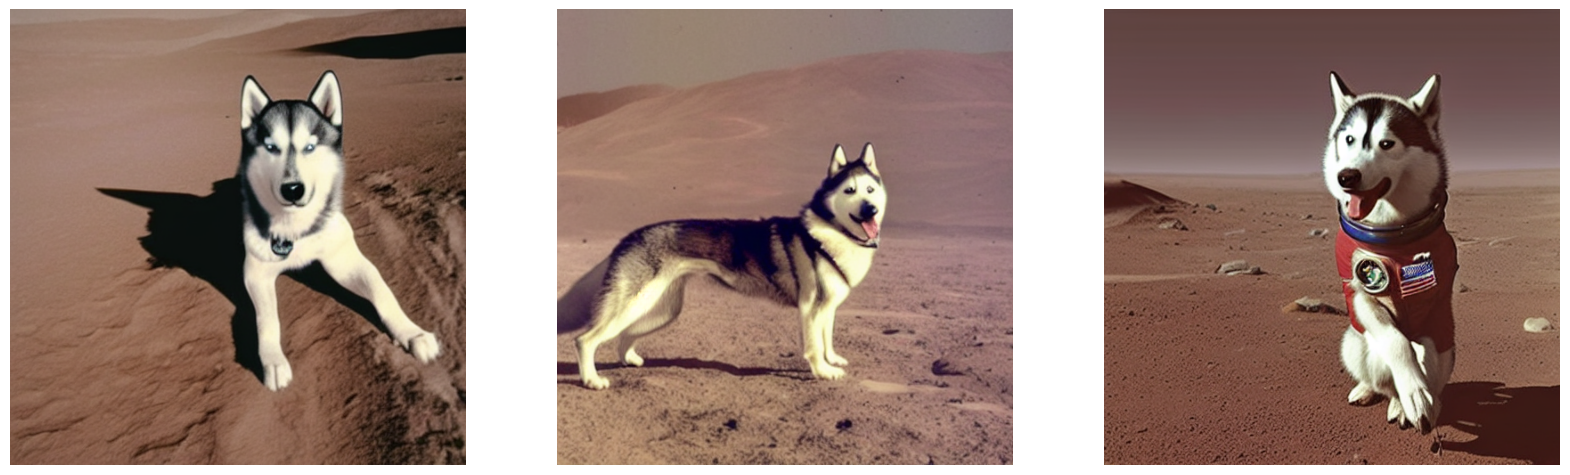

In [4]:
images = model.text_to_image("photograph of a husky as an astronaut on Mars", batch_size=3)

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(images)

This produced the images at the top of the notebook. It took about 12 minutes on a heavy-duty desktop with an advanced Nvidia GPU to run.

But it should also run on your laptop, provided you have Gigs of space to spare.

The architecture of that neural network used for denoising is a U-Net with identical input and output dimensions. 

U-Net is a popular semantic segmentation architecture, whose main idea is that it progressively downsamples and then upsamples its input image, and adds skip connections between layers having the same resolution. 

One can view diffusion models as denoising autoencoders, instead of *variational autoencoders* (VAEs), but in a big way there are similar to VAEs because they deal with statistics of the label.

The network takes two inputs, the noisy images and the *variances* of their noise components. The latter is required since denoising a signal requires different operations at different levels of noise. 

Noise variances are tranformed using sinusoidal embeddings, similarly to positional encodings used in transformers. This helps the network to be highly sensitive to the noise level, which is crucial for good performance.

## Diffusion schedule
Let us say, that a diffusion process starts at time = 0, and ends at time = 1. This variable will be called *diffusion time*, and can be either discrete (common in diffusion models) or continuous (common in score-based models).

We need to have a function that tells us at each point in the diffusion process the noise levels and signal levels of the noisy image corresponding to the actual diffusion time. This will be called the *diffusion schedule*.

## Training process
The training procedure of denoising diffusion models is the following: Random diffusion times are sampled uniformly and the training images are mixed with random gaussian noises at rates corresponding to the diffusion times. 

Then, the model is trained to separate the noisy image to its two components.

By running the training for 50 epochs (2 hours on a T4 GPU and 30 minutes on an A100 GPU), one can get high quality image generations from seemingly random noise.

Now, to go from latent diffusion to a text-to-image system, we still need to add one key feature: the ability to control the generated visual contents via prompt keywords. 

So the next step is to add text labels to each image in the training dataset, so that text label inputs can generate appropriate image hallucinations, not too differently than what we did in our image-to-text notebooks (except that we can't really afford to run this training on our laptops anymore).

This is done via *conditioning*, a classic deep learning technique which consists of concatenating to the noise patch a thought vector that represents a bit of text, then training the model on a dataset of {image: caption} pairs.

This gives rise to the Stable Diffusion architecture. 

So, Stable Diffusion consists of three parts:

- A text encoder, which turns your prompt into a latent vector: Simply a pretrained, frozen language model.
- A diffusion model, which repeatedly "denoises" a 64x64 latent image patch.
- A decoder, which turns the final 64x64 latent patch into a higher-resolution 512x512 image.

<br />
<center>
<img src="ipynb.images/ml-denoising-into-flowers.gif" width=600 />
</center>

First, your text prompt gets projected into a latent vector space by the text encoder. Then that prompt vector is concatenated to a randomly generated noise patch, which is repeatedly *denoised* by the diffusion model over a series of steps (the more steps you run the clearer and nicer your image will be -- the default value is 50 steps).

Finally, the 64x64 latent image is sent through the decoder to properly render it in high resolution.

<br />
<center>
<img src="ipynb.images/ml-stable-diffusion-husky.png" width=900 />
</center>

The `KerasCv` implementation is competitive (actually allegedly by 30% faster on Tesla T4 and Tesla V100 GPUs with warm start, and about half as fast with cold-start execution, which includes the one-time cost of model creation and compilation) with [HUggingFace diffusers](https://github.com/huggingface/diffusers), except that the latter runs on `pytorch` instead of `tensorflow`, and Dino is a tensorflow afficionado.

# Homework
### huskies dancing tango
>Prompt: *Huskies on the roof of a building, dancing the jitterbug*


 Huskies on the roof of a building, dancing the tango

In [5]:
images = model.text_to_image(" Huskies on the roof of a building, dancing the tango", batch_size=3)


50/50 [==============================] - 1069s 21s/step


In [6]:
images

array([[[[111, 117, 115],
         [135, 138, 145],
         [110, 117, 121],
         ...,
         [166, 188, 226],
         [166, 188, 229],
         [169, 191, 226]],

        [[ 92, 104, 121],
         [102, 114, 137],
         [110, 119, 137],
         ...,
         [170, 188, 227],
         [170, 186, 228],
         [166, 186, 232]],

        [[140, 162, 173],
         [139, 156, 177],
         [143, 157, 175],
         ...,
         [169, 187, 226],
         [170, 188, 226],
         [169, 190, 229]],

        ...,

        [[145, 134, 127],
         [175, 176, 183],
         [118, 119, 131],
         ...,
         [124, 125, 128],
         [120, 118, 123],
         [119, 118, 121]],

        [[150, 142, 135],
         [177, 178, 184],
         [122, 122, 136],
         ...,
         [125, 125, 127],
         [120, 119, 122],
         [118, 119, 119]],

        [[160, 155, 151],
         [170, 174, 184],
         [119, 124, 143],
         ...,
         [121, 123, 126],
        

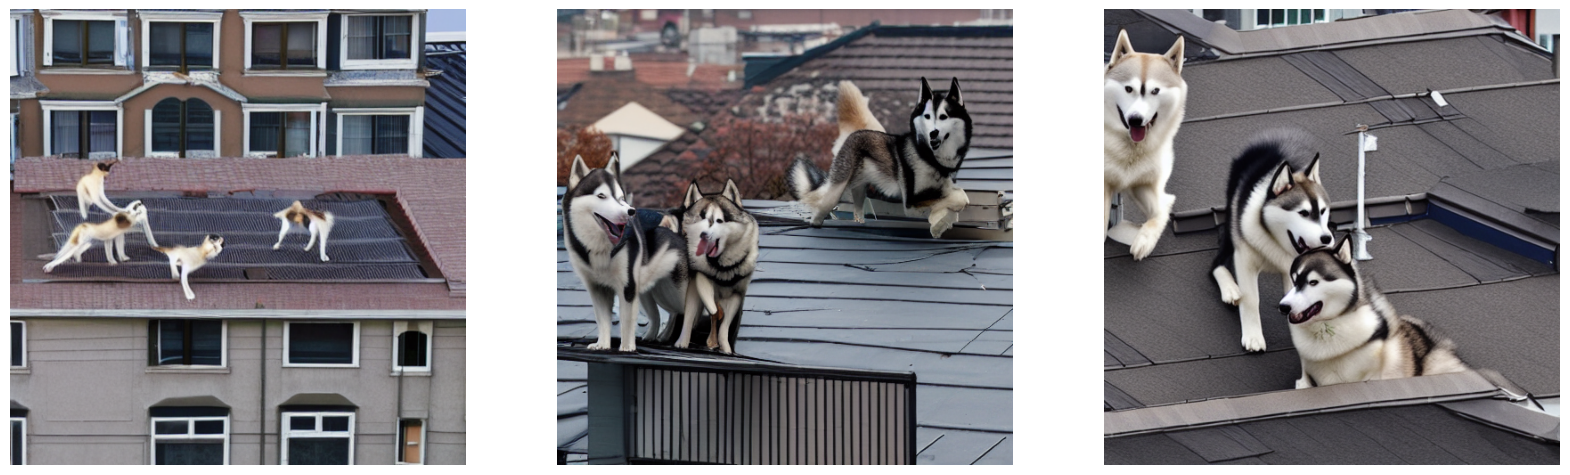

In [7]:

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(images)